In [10]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sqlalchemy.engine import Engine
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

base_path = "/media/bruno/Arquivos/Desenvolvimento/WineQuality"
load_dotenv(f"{base_path}/config/.env")

True

In [2]:
def get_engine() -> Engine:
    user = os.getenv("DB_USER")
    pw = os.getenv("DB_PASS")
    db = os.getenv("DB_NAME")
    host = os.getenv("DB_HOST")
    port = os.getenv("DB_PORT")
    return create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

Uma das características marcantes dos vinhos para os apreciadores é o aroma. Quimicamente, compostos voláteis são responsáveis por dar essa característica à bebida. Por outro lado, o gosto amargo é resultante da oxidação do álcool, seja pela exposição ao ar atmosférico ou devido ao próximo oxigênio que pode estar dissolvido no vinho. Assim, uma parte interessante é avaliar a nota do vinho com algumas substâncias chave.

Observando a composição relativa, o pH não apresenta uma diferença tão crucial entre os vinhos de alta qualidade e baixa qualidade. Isso significa que a diferença não está no potencial atual, mas sim após. O processo de degustação de vinhos envolve uma espera entre a disposição na taça e a devida ingestão, tempo em que o líquido fica em contato com o ar, podendo sofrer oxidação. Por que os vinhos de alta qualidade não oxidam? Dois pontos são revelados:

1. Maior quantidade de ácidos cítricos;
2. Menor quantidade de dióxido de enxofre.

Os dados apresentados validam a teoria química de equilíbrio. Com maior concentração de ácido (causada pelo ácido cítrico), a reação de oxidação do álcool se torna menos favorável entropicamente, o que mantêm o teor alcóolico dos vinhos de qualidade elevado. Junto disso, o dióxido de enxofre que é altamente capaz de ionizar o álcool e iniciar a reação de oxidação também apresenta menor concentração.

Essa poderosa combinação também permite a existência de maior quantidade de açúcares nos vinhos de alta qualidade, que não são utilizados para fermentação e podem exercer a função de potencializar o sabor da bebida.

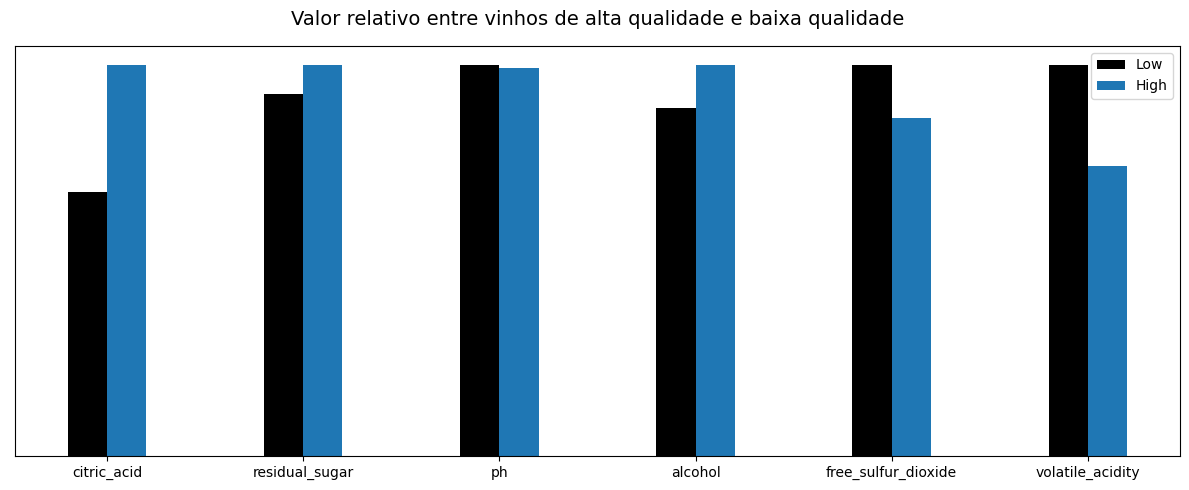

In [3]:
def show_relation():
    engine = get_engine()
    with engine.connect() as conn:
        query = """
            select
                avg(s.citric_acid) as citric_acid,
                avg(s.residual_sugar) as residual_sugar,
                avg(s.ph) as ph,
                avg(s.alcohol) as alcohol,
                avg(s.free_sulfur_dioxide) as free_sulfur_dioxide,
                avg(s.volatile_acidity) as volatile_acidity,
                s.classification as category
            from (
                select
                    *,
                    if(quality >= 7, 'HIGH', 'LOW') as classification
                from wine_results
            ) as s
            group by s.classification
        """
        dataset = pd.read_sql(query, conn)
        
        labels = ["citric_acid", "residual_sugar", "ph", "alcohol", "free_sulfur_dioxide", "volatile_acidity"]
        low_values = [dataset.query("category == 'LOW'")[l].values[0] / max(dataset[l].values) for l in labels]
        high_values = [dataset.query("category == 'HIGH'")[l].values[0] / max(dataset[l].values) for l in labels]

        x = np.arange(len(labels))
        width = 0.2

        fig, ax = plt.subplots(figsize=(12, 5))
        ax.bar(x - width / 2, low_values, width, label="Low", color="#000")
        ax.bar(x + width / 2, high_values, width, label="High")

        ax.set_title("Valor relativo entre vinhos de alta qualidade e baixa qualidade", fontdict={"fontsize": 14}, pad=15)
        ax.set_xticks(x, labels)
        ax.set_yticks([])
        ax.legend()

        fig.tight_layout()
        plt.show()

show_relation()

Uma avaliação de existência de correlação linear revela algumas coisas interessantes. Primeiro é importante comentar a remoção das colunas de pH e acidez. Por definição, estes valores estão relacionados entre si, como pode ser observado nas equações 1 e 2. Também, por se tratar de uma análise linear e, em casos complexos como o do vinho, estas equações possuem expoentes diferentes de 1.

Equação 1: $pH = -log [H^{+}]$

Equação 2: $Ka = \frac{[H^{+}] [A{-}]}{[HA]}$

Todavia, não se prendendo ao ponto do pH, todas as correlações encontradas atingem no máximo o nível moderado, como entre ácido cítrico e volatilidade. Porém os sinais revelam algumas coisas importantes. A observação feita anteriormente começa a ser fundamentada de forma numérica, uma vez que existe uma certa tendência da composição de ácido cítrico ser inversamente proporcional às concentrações de dióxido de enxofre e volatilidade. Identificamos acima que estas duas variáveis são mais fracas em vinhos de alta qualidade, de modo que a presença de ácido cítrico pode ser um forte indicador de melhoria da qualidade do produto.

In [4]:
def show_correlation():
    engine = get_engine()
    with engine.connect() as conn:
        query = """
            select
                -- w.fixed_acidity,
                w.volatile_acidity,
                w.citric_acid,
                w.residual_sugar,
                w.chlorides,
                w.free_sulfur_dioxide,
                -- w.total_sulfur_dioxide,
                w.density,
                -- w.ph,
                w.sulphates,
                w.alcohol
            from wine_results w
        """
        dataset = pd.read_sql(query, conn)
        print(dataset.corr())


show_correlation()

                     volatile_acidity  citric_acid  residual_sugar  chlorides  \
volatile_acidity             1.000000    -0.552496        0.001918   0.061298   
citric_acid                 -0.552496     1.000000        0.143577   0.203823   
residual_sugar               0.001918     0.143577        1.000000   0.055610   
chlorides                    0.061298     0.203823        0.055610   1.000000   
free_sulfur_dioxide         -0.010504    -0.060978        0.187049   0.005562   
density                      0.022026     0.364947        0.355283   0.200632   
sulphates                   -0.260987     0.312770        0.005527   0.371260   
alcohol                     -0.202288     0.109903        0.042075  -0.221141   

                     free_sulfur_dioxide   density  sulphates   alcohol  
volatile_acidity               -0.010504  0.022026  -0.260987 -0.202288  
citric_acid                    -0.060978  0.364947   0.312770  0.109903  
residual_sugar                  0.187049  0.3552

Após as discussões anteriores, fica evidente a necessidade de avaliar com mais cuidado quais variáveis continuarão no radar de análise. Uma primeira abordagem pode ser feita a partir da matriz de correlação, mas ainda bem introdutória, visto que nesta metodologia a busca é por relações lineares. Uma segunda abordagem é por meio da variância, atendendo um valor mínimo. Dado que as variáveis se encontram em diferentes escalas, um passo adicional seria necessário para definir esse valor de corte.

Para simplificar a implementação, o método de seleção adotado foi o de melhor pontuação em um teste estatístico de cada feature contra o target. Como este é um problema de classificação, o teste escolhido foi o qui-quadrado e o top adotado foi de 5. De fato, a seleção dos melhores scores apontou para a discussão das variáveis que já foram trabalhadas anteriormente, a partir da teoria que envolvem os compostos químicos apresentados. Sulfato, volatilidade, ácido cítrico e teor alcoólico são variáveis que pela teoria seriam de fato as mais impactantes na qualidade do vinho e já foram discutidas e avaliadas anteriormente.

Quando a distribuição dessas variáveis são confrontadas nos dois casos (baixa qualidade e alta qualidade), uma observação interessante é na redução de valores extremos no caso de vinhos de alta qualidade, quando comparados com os de baixa. Tal fato pode ser um indicador de maior homogeneidade deste grupo em relação ao outro.

Seleção de features com melhor score:
 > volatile_acidity
 > citric_acid
 > free_sulfur_dioxide
 > total_sulfur_dioxide
 > alcohol


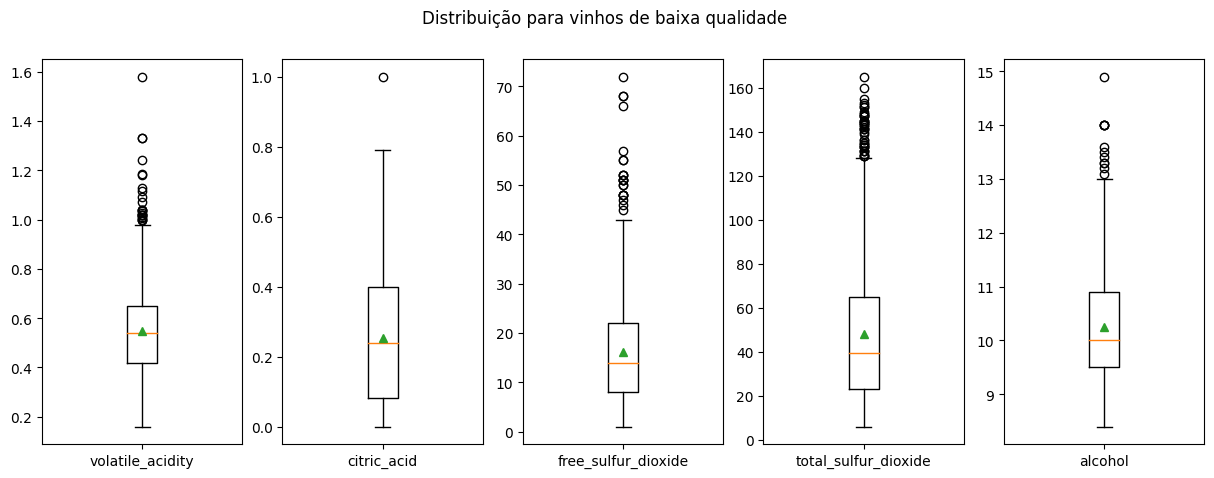

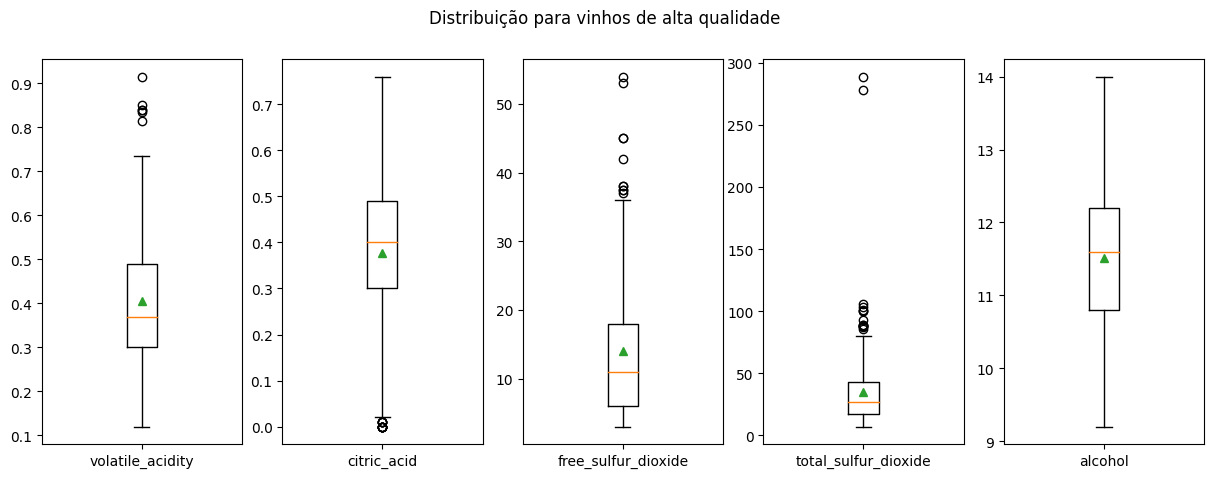

In [5]:
def selection():
    engine = get_engine()
    with engine.connect() as conn:
        query = """
            select
                w.fixed_acidity,
                w.volatile_acidity,
                w.citric_acid,
                w.residual_sugar,
                w.chlorides,
                w.free_sulfur_dioxide,
                w.total_sulfur_dioxide,
                w.density,
                w.ph,
                w.sulphates,
                w.alcohol,
                w.quality
            from wine_results w
        """
        dataset = pd.read_sql(query, conn)

        selector = SelectKBest(chi2, k=5)
        selector.fit(dataset.values[:, :-1], dataset.values[:, -1])
        features = selector.get_feature_names_out(input_features=dataset.columns[:-1])

        print("Seleção de features com melhor score:")
        for feature in features:
            print(f" > {feature}")

        fig, ax = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle("Distribuição para vinhos de baixa qualidade")
        subset = dataset.query("quality < 7")
        for i in range(0, len(features)):
            ax[i].boxplot(subset[features[i]].values, labels=[features[i]], showmeans=True)

        fig, ax = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle("Distribuição para vinhos de alta qualidade")
        subset = dataset.query("quality >= 7")
        for i in range(0, len(features)):
            ax[i].boxplot(subset[features[i]].values, labels=[features[i]], showmeans=True)

        plt.show()

selection()

Uma análise interessante é aplicar uma abordagem não supervisionada nas features, no intuito de verificar se existe uma certa homogeneia tendência das variáveis avaliadas nesses subgrupos. Para escolha do número de clusters foi utilizado o método do cotovelo, identificando o ponto de máxima queda na métrica da inércia. Dado que o método de KMeans utiliza distância euclidiana e este projeto utiliza diversas features em escalas diferentes, uma normalização foi aplicada para melhor aplicabilidade dos cálculos do modelo.

Se categorizarmos os valores numéricos em ALTO, MÉDIO e BAIXO, temos que:

| Cluster | Volatilidade | Ácido cítrico | Sulfato | Teor Alcoólico |
| ------- | ------------ | ------------- | ------- | -------------- |
| 0 | ALTO   | BAIXO | MÉDIO | MÉDIO |
| 1 | BAIXO  | ALTO  | BAIXO | MÉDIO |
| 2 | MÉDIO  | MÉDIO | ALTO  | MÉDIO |
| 3 | BAIXO  | ALTO  | MÉDIO | ALTO  |

De modo geral, os clusters tendem a centralizar em uma determinada variável, com as demais se mantendo constantes ao seu redor. Dessa forma seria possível classificar vinhos com alta volatilidade, alta de ácidos cítricos, alta de sulfatos ou alto de teor alcoólico. Todavia, esse agrupamento numérico não parece refletir na pontuação do vinho, ou seja, na qualidade. Assim, o próximo notebook terá como foco modelar a forma de classificar o vinho a partir dessas variáveis, não se limitando na parte descritiva dos dados.

In [17]:
def analysis_cluster():
    engine = get_engine()
    with engine.connect() as conn:
        query = """
            select
                w.volatile_acidity,
                w.citric_acid,
                w.free_sulfur_dioxide,
                w.total_sulfur_dioxide,
                w.alcohol,
                if(w.quality >= 7, 'HIGH', 'LOW') as quality
            from wine_results w
        """
        dataset = pd.read_sql(query, conn)

        clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
        features = dataset.values[:, :-1]
        columns = dataset.columns[:-1]
        metrics, distances = [], []

        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        for nc in clusters:
            kmeans = KMeans(n_clusters=nc).fit(features)
            metrics.append(kmeans.inertia_)

        for i in range(0, len(clusters)):
            x0, x1 = clusters[0], clusters[-1]
            y0, y1 = metrics[0], metrics[-1]
            x, y = clusters[i], metrics[i]
            
            num = abs(x * (y1 - y0) - y * (x1 - x0) + x1 * y0 - y1 * x0)
            dem = np.sqrt(np.power(y1 - y0, 2) + np.power(x1 - x0,2))
            distances.append(num / dem)

        optimal = clusters[distances.index(max(distances))]
        print(f"O número ótimo de clusters é {optimal}")

        kmeans = KMeans(n_clusters=optimal).fit(features)
        dataset["cluster"] = kmeans.predict(features)
        result = []

        for cluster in dataset["cluster"].unique():
            subset = dataset.query(f"cluster == {cluster}")
            registry = {"cluster": cluster}

            for column in columns:
                registry[column] = np.mean(subset[column].values)
            result.append(registry)

            for quality in subset["quality"].unique():
                count = list(subset["quality"].values).count(quality)
                registry[quality] = round(round(count * 100 / len(subset), 2))

        result = pd.DataFrame(result)
        print(result)


analysis_cluster()

O número ótimo de clusters é 4
   cluster  volatile_acidity  citric_acid  free_sulfur_dioxide  \
0        1          0.668221     0.094801            12.263385   
1        3          0.410471     0.447264            10.446809   
2        2          0.528312     0.280128            28.760870   
3        0          0.384900     0.405733            12.003333   

   total_sulfur_dioxide    alcohol  LOW  HIGH  
0             34.255613  10.224669   94     6  
1             32.446809   9.903090   88    12  
2             88.818414  10.018883   95     5  
3             30.216667  11.902556   58    42  
